### **yolov1论文**

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
import math

**一、搭建模型**

**backbone采用VGG架构**

In [2]:
def get_yolov1(num_classes = 20,num_bboxes = 2):
    """获取yolov1模型"""
    return nn.Sequential(
        nn.Conv2d(3,64,kernel_size = 7,stride = 2,padding = 3),nn.ReLU(),
        nn.MaxPool2d(2,2),                    # k = 2,s = 2的MaxPool2d层使图像分辨率减半
        nn.Conv2d(64,192,kernel_size = 3,padding = 1),nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(192,128,1),nn.ReLU(),
        nn.Conv2d(128,256,3,padding = 1),nn.ReLU(),
        nn.Conv2d(256,256,1),nn.ReLU(),
        nn.Conv2d(256,512,3,padding = 1),nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(512,256,1),nn.ReLU(),
        nn.Conv2d(256,512,3,padding = 1),nn.ReLU(),
        nn.Conv2d(512,256,1),nn.ReLU(),
        nn.Conv2d(256,512,3,padding = 1),nn.ReLU(),
        nn.Conv2d(512,256,1),nn.ReLU(),
        nn.Conv2d(256,512,3,padding = 1),nn.ReLU(),
        nn.Conv2d(512,256,1),nn.ReLU(),
        nn.Conv2d(256,512,3,padding = 1),nn.ReLU(),
        nn.Conv2d(512,512,1),nn.ReLU(),
        nn.Conv2d(512,1024,3,padding = 1),nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(1024,512,1),nn.ReLU(),
        nn.Conv2d(512,1024,3,padding = 1),nn.ReLU(),
        nn.Conv2d(1024,512,1),nn.ReLU(),
        nn.Conv2d(512,1024,3,padding = 1),nn.ReLU(),
        nn.Conv2d(1024,1024,3,padding = 1),nn.ReLU(),
        nn.Conv2d(1024,1024,3,stride = 2,padding = 1),nn.ReLU(),
        nn.Conv2d(1024,1024,3,padding = 1),nn.ReLU(),
        nn.Conv2d(1024,1024,3,padding = 1),nn.ReLU(),
        nn.Flatten(),nn.Linear(7 * 7 * 1024,4096),nn.ReLU(),
        nn.Linear(4096,7 * 7 * (num_bboxes * 5 + num_classes)),nn.ReLU()
    )

class Yolov1(nn.Module):
    def __init__(self,num_classes = 20,num_bboxes = 2):
        super().__init__()
        self.B = num_bboxes
        self.C = num_classes
        self.layer = get_yolov1(self.C,self.B)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
        
    def forward(self,X):
        X = self.layer(X)
        X = X.reshape(X.shape[0],self.B * 5 + 
                      self.C,7,7)
        return X

In [3]:
net = Yolov1()

In [4]:
input = torch.rand((1,3,448,448)) # 通道优先
y_pred = net(input).reshape(1,30,7,7)
# y_pred = net(input)
print(y_pred.shape)

torch.Size([1, 30, 7, 7])


In [5]:
print(summary(net,input_data = input))

Layer (type:depth-idx)                   Output Shape              Param #
Yolov1                                   [1, 30, 7, 7]             --
├─Sequential: 1-1                        [1, 1470]                 --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         9,472
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 192, 112, 112]        110,784
│    └─ReLU: 2-5                         [1, 192, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 192, 56, 56]          --
│    └─Conv2d: 2-7                       [1, 128, 56, 56]          24,704
│    └─ReLU: 2-8                         [1, 128, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          295,168
│    └─ReLU: 2-10                        [1, 256, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          6

**二、定义损失函数**

In [6]:
class YoloLoss(nn.Module):
    """定义一个为yolov1的损失函数"""

    def __init__(self,feature_size=7, num_bboxes=2, num_classes=20, lambda_coord=5.0, lambda_noobj=0.5):
        super().__init__()
        self.S = feature_size
        self.B = num_bboxes
        self.C = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def compute_iou(self,bbox1,bbox2):
        """"
        计算两组边界框之间的交并比(IoU)
        
        参数:
        - bbox1: 形状为 [N, 4] 的边界框 (xmin, ymin, xmax, ymax)
        - bbox2: 形状为 [M, 4] 的边界框 (xmin, ymin, xmax, ymax)
        
        返回:
        - iou: 形状为 [N, M] 的 IoU 矩阵
        """
        # 获取边界框数量
        N = bbox1.size(0)
        M = bbox2.size(0)
        
        # 计算交集的左上角坐标 (left-top)
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2),  # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)   # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        
        # 计算交集的右下角坐标 (right-bottom)
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2),  # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)    # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        
        # 计算交集的宽高
        wh = rb - lt
        wh[wh < 0] = 0  # 处理无重叠的情况
        inter = wh[:, :, 0] * wh[:, :, 1]  # 交集面积 [N, M]
        
        # 计算两个边界框各自的面积
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1])  # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1])  # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter)  # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter)  # [M, ] -> [1, M] -> [N, M]
        
        # 计算并集面积
        union = area1 + area2 - inter  # [N, M]
        
        # 计算 IoU
        iou = inter / union  # [N, M]
        
        return iou


    def forward(self,pred:torch.Tensor,target:torch.Tensor):
        """
        计算 YOLOv1 损失
        
        参数:
        - pred_tensor: 模型预测的输出张量，形状为 [batch_size, S, S, B*5 + C]
        - target_tensor: 目标标签张量，形状与 pred_tensor 相同
        
        返回:
        - loss: 计算得到的损失值
        """
        # target/pred = (N,C,H,W) -> (N,H,W,C)
        device = target.device
        target = target.permute(0,2,3,1)
        pred = pred.permute(0,2,3,1)
        batch_size = pred.shape[0]

        # breakpoint()

        # 设置临时参数，减少重复self引用
        S = self.S
        B = self.B
        C = self.C
        grid_size = 1.0 / S # 归一化的网格大小

        # 设置有目标的mask和没目标的mask
        coord_mask = target[:,:,:,4] > 0
        noobj_mask = target[:,:,:,4] == 0
        coord_mask = coord_mask.unsqueeze(-1).expand_as(target)
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target)

        # 提取有目标的pred和没目标的pred
        coord_pred = pred[coord_mask].reshape(-1, 5 * B + C)
        noobj_pred = pred[noobj_mask].reshape(-1, 5 * B + C)

        # 提取有目标的target和没目标的target
        coord_target = target[coord_mask].reshape(-1, 5 * B + C)
        noobj_target = target[noobj_mask].reshape(-1, 5 * B + C)

        # 提取bbox与class
        bbox_pred = coord_pred[:,:5 * B].reshape(-1, 5)
        class_pred = coord_pred[:,5 * B:]
        bbox_target = coord_target[:,:5 * B].reshape(-1, 5)
        class_target = coord_target[:,5 * B:]

        # 处理无目标位置的置信度损失
        noobj_conf_mask = torch.BoolTensor(noobj_pred.shape).fill_(0).to(device)
        for b in range(B):
            noobj_conf_mask[:,4 + b * 5] = 1 # 设置提取出置信度的位置
        noobj_conf_pred = noobj_pred[noobj_conf_mask]
        noonj_conf_target = noobj_target[noobj_conf_mask]

        # 计算noobj_loss_conf
        loss_conf_noobj = F.mse_loss(noobj_conf_pred,noonj_conf_target,reduction = 'sum')

        # 初始化响应掩码
        coord_response_mask = torch.BoolTensor(bbox_target.size()).fill_(0).to(device) # 响应初始化为0
        coord_not_response_mask = torch.BoolTensor(bbox_target.size()).fill_(1).to(device) # 非响应初始化为1
        bbox_target_iou = torch.zeros(bbox_target.size()).to(device)

        # 遍历每个目标网格
        for i in range(0,bbox_pred.shape[0],B):
            # 获取当前网格的 B 个预测边界框
            pred = bbox_pred[i:i + B] 

            # 将预测边界框转换为 (xmin, ymin, xmax, ymax) 格式
            pred_xyxy = torch.zeros((pred.shape[0],4)).to(device)
            pred_xyxy[:,:2] = pred[:,:2] * grid_size - pred[:,2:4] * 0.5    # 左上
            pred_xyxy[:,2:4] = pred[:,:2] * grid_size + pred[:,2:4] * 0.5   # 右下

            # 同样处理出目标坐标
            target = bbox_target[i].reshape(-1,5)
            target_xyxy = torch.zeros((target.shape[0],4)).to(device)
            target_xyxy[:,:2] = target[:,:2] * grid_size - target[:,2:4] * 0.5    # 左上
            target_xyxy[:,2:4] = target[:,:2] * grid_size + target[:,2:4] * 0.5   # 右下

            # 计算iou
            iou = self.compute_iou(pred_xyxy,target_xyxy)
            max_iou, max_index = iou.max(0)  # 找出最大 IoU 及其索引

            # 标记负责预测目标的边界框
            coord_response_mask[i + max_index] = 1
            coord_not_response_mask[i + max_index] = 0

            # 将最大 IoU 作为置信度目标
            bbox_target_iou[i + max_index,4] = max_iou.data

        # 提取负责预测目标的边界框
        bbox_pred_response = bbox_pred[coord_response_mask].reshape(-1, 5)
        bbox_target_response = bbox_target[coord_response_mask].reshape(-1, 5)
        target_iou = bbox_target_iou[coord_response_mask].reshape(-1, 5)

        # 计算坐标损失 (中心点坐标)
        loss_xy = F.mse_loss(bbox_pred_response[:, :2], bbox_target_response[:, :2], reduction='sum')

        
        # 计算宽高损失
        loss_wh = F.mse_loss(
            torch.sqrt(bbox_pred_response[:,2:4]), 
            torch.sqrt(bbox_target_response[:,2:4]), 
            reduction = 'sum'
        )

        # 计算目标置信度损失
        loss_conf = F.mse_loss(bbox_pred_response[:,4], target_iou[:,4], reduction = 'sum')

        # 计算类别预测损失
        loss_class = F.mse_loss(class_pred,class_target,reduction = 'sum')

        print(loss_xy,loss_wh,loss_class,loss_conf,loss_conf_noobj)
        print(target_iou[:,4])

        loss = (self.lambda_coord * (loss_xy + loss_wh) + 
                self.lambda_noobj * loss_conf_noobj +
                loss_conf + loss_class)
        
        return loss / batch_size # 平均损失

**三、训练**

In [15]:
# 加载数据
from utils.datasets import YoloData
import torchvision
from torch.utils import data
from utils.net_frame import *

In [16]:
# 定义图像transforms
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std  = [0.229, 0.224, 0.225]
    ),torchvision.transforms.Resize((448,448))]
)
# 加载数据集
yolodata = YoloData("datasets/JPEGImages","datasets/train.txt",transforms = transforms)

Extract dataset:   0%|          | 0/13700 [00:00<?, ?it/s]

Generating targets: 100%|██████████| 13700/13700 [00:03<00:00, 3933.13it/s]


In [17]:
batch_size = 128
train_iter = data.DataLoader(yolodata,batch_size = 128,shuffle = True)

In [23]:
lr = 5e-4
loss = YoloLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [24]:
from tqdm import tqdm

# 定义训练函数
def train(net,trainer,train_iter,test_iter,loss_fn,lr,num_epochs,devices_idx = None):
    """训练"""
    # 设置设备
    if devices_idx == None:
        device = try_gpu(i = 0)
    else:
        assert (type(devices_idx == list) and 
                type(devices_idx[0]) == int),"devices_idx must be list of int"
        devices = [torch.device(f"cuda:{i}")
                   for i in devices_idx]
    print(f"Training on{devices}")
    
    # 多GPU加载网络(当len(devices) == 1时即单卡训练)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    # 开始训练
    loss_plt = []
    train_accs = []
    test_accs = []
    for epoch in range(num_epochs):
        net.train() # 循环涉及评估，则每次循环前要net.train()
        loop = tqdm(train_iter,desc = f"Epoch:[{epoch + 1}/{num_epochs}]",
                    total = len(train_iter))
        loss_temp = 0
        total_nums = 0
        for batch in loop:
            # 清空梯度
            trainer.zero_grad()

            # forward
            X,Y = batch
            if type(X) == list:
                X = [x.to(devices[0]) for x in X]
                total_nums += X[0].shape[0]
            else:
                X = X.to(devices[0]) # 放置在devices[0]即可
                total_nums += X.shape[0]
            Y = Y.to(devices[0])
            # print(X.shape,Y.shape)
            y_pred = net(X)

            # count loss and backwar
            loss = loss_fn(y_pred,Y)
            loss.sum().backward()
            trainer.step()

            # 先step后再调用item()，否则切断计算图
            loss_temp += loss.sum().item()

            return None
            
            # # update parameters
            # trainer.step()
            loop.set_postfix({"LOSS" : loss_temp / total_nums,"lr" : "{:e}".format(trainer.param_groups[0]['lr'])})
        loss_plt.append(loss_temp / total_nums)
    return loss_plt,train_accs,test_accs

In [25]:
plt_loss = train(net,trainer,train_iter,test_iter = None,loss_fn = loss,
                 num_epochs = 20,lr = lr,devices_idx = [4])

Training on[device(type='cuda', index=4)]


Epoch:[1/20]:   0%|          | 0/108 [00:00<?, ?it/s]

tensor(nan, device='cuda:4', grad_fn=<MseLossBackward0>) tensor(nan, device='cuda:4', grad_fn=<MseLossBackward0>) tensor(nan, device='cuda:4', grad_fn=<MseLossBackward0>) tensor(nan, device='cuda:4', grad_fn=<MseLossBackward0>) tensor(nan, device='cuda:4', grad_fn=<MseLossBackward0>)
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

**四、端到端的预测推理**

分三个步骤:
- 图像预处理，转换为模型输入格式
- 网络推理，得到输出张量
- 后处理，解析输出张量

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torchvision
from utils.net_frame import try_gpu
def preprocess(img_path,transforms):
    """图像预处理"""
    mode = torchvision.io.image.ImageReadMode.RGB
    img = torchvision.io.read_image(img_path,mode)
    img = img.float() / 255 # 浮点化、归一化
    input_tensor = transforms(img)
    input_tensor = input_tensor.unsqueeze(0) # 添加批量维度
    return input_tensor

def model_infer(net,input_tensor,device_idx = None):
    """模型推理"""
    if device_idx == None:
        device = try_gpu(i = 0)
    else:
        device = try_gpu(device_idx)
    net.eval()
    net.to(device)
    input_tensor = input_tensor.to(device)
    out_tensor = net(input_tensor)
    return out_tensor

def nms(boxes, scores,threshold):

    x1 = boxes[:, 0]  # [n,]
    y1 = boxes[:, 1]  # [n,]
    x2 = boxes[:, 2]  # [n,]
    y2 = boxes[:, 3]  # [n,]
    areas = (x2 - x1) * (y2 - y1)  # [n,]

    _, ids_sorted = scores.sort(0, descending=True)  # [n,]
    ids = []
    while ids_sorted.numel() > 0:
        # Assume `ids_sorted` size is [m,] in the beginning of this iter.

        i = ids_sorted.item() if (ids_sorted.numel() == 1) else ids_sorted[0]
        ids.append(i)

        if ids_sorted.numel() == 1:
            break  # If only one box is left (i.e., no box to supress), break.

        inter_x1 = x1[ids_sorted[1:]].clamp(min=x1[i])  # [m-1, ]
        inter_y1 = y1[ids_sorted[1:]].clamp(min=y1[i])  # [m-1, ]
        inter_x2 = x2[ids_sorted[1:]].clamp(max=x2[i])  # [m-1, ]
        inter_y2 = y2[ids_sorted[1:]].clamp(max=y2[i])  # [m-1, ]
        inter_w = (inter_x2 - inter_x1).clamp(min=0)  # [m-1, ]
        inter_h = (inter_y2 - inter_y1).clamp(min=0)  # [m-1, ]

        inters = inter_w * inter_h  # intersections b/w/ box `i` and other boxes, sized [m-1, ].
        unions = areas[i] + areas[ids_sorted[1:]] - inters  # unions b/w/ box `i` and other boxes, sized [m-1, ].
        ious = inters / unions  # [m-1, ]

        # Remove boxes whose IoU is higher than the threshold.
        ids_keep = (ious <= threshold).nonzero().squeeze()  # [m-1, ]. Because `nonzero()` adds extra dimension, squeeze it.
        if ids_keep.numel() == 0:
            break  # If no box left, break.
        ids_sorted = ids_sorted[ids_keep + 1]  # `+1` is needed because `ids_sorted[0] = i`.

    return torch.LongTensor(ids)


def decode(pred_tensor,grid_size,num_bboxes,conf_thresh,prob_thresh,nb_classes):

    S, B, C = grid_size,num_bboxes,nb_classes
    boxes, labels, confidences, class_scores = [], [], [], []

    cell_size = 1.0 / float(S)

    pred_tensor = pred_tensor.cpu().data.squeeze(0)

    pred_tensor_conf_list = []
    for b in range(B):
        pred_tensor_conf_list.append(pred_tensor[:, :, 5 * b + 4].unsqueeze(2))
    grid_ceil_conf = torch.cat(pred_tensor_conf_list, 2)

    grid_ceil_conf, grid_ceil_index = grid_ceil_conf.max(2)
    class_conf, class_index = pred_tensor[:, :, 5 * B:].max(2)
    class_conf[class_conf <= conf_thresh] = 0
    class_prob = class_conf * grid_ceil_conf

    for i in range(S):
        for j in range(S):
            if float(class_prob[j, i]) < prob_thresh:
                continue
            box = pred_tensor[j, i, 5 * grid_ceil_index[j, i]: 5 * grid_ceil_index[j, i] + 4]
            xy_start_pos = torch.FloatTensor([i, j]) * cell_size
            xy_normalized = box[:2] * cell_size + xy_start_pos
            wh_normalized = box[2:]
            box_xyxy = torch.FloatTensor(4)
            box_xyxy[:2] = xy_normalized - 0.5 * wh_normalized
            box_xyxy[2:] = xy_normalized + 0.5 * wh_normalized

            boxes.append(box_xyxy)
            labels.append(class_index[j, i])
            confidences.append(grid_ceil_conf[j, i])
            class_scores.append(class_conf[j, i])

    # print(boxes[0].shape,labels[0].shape,confidences[0].shape,class_scores[0].shape)

    if len(boxes) > 0:
        boxes = torch.stack(boxes, 0)
        labels = torch.stack(labels, 0)
        confidences = torch.stack(confidences, 0)
        class_scores = torch.stack(class_scores, 0)
    else:
        boxes = torch.FloatTensor(0, 4)
        labels = torch.LongTensor(0)
        confidences = torch.FloatTensor(0)
        class_scores = torch.FloatTensor(0)

    return boxes, labels, confidences, class_scores

def postprocess(output,width, height,VOC_CLASSES,grid_size,num_bboxes,conf_thresh,prob_thresh,nms_thresh,nb_classes):
    output = output.permute(0,2,3,1) # (N,C,H,W) -> (N,H,W,C)

    boxes,labels,probs = [],[],[]

    boxes_list, labels_list, confidences_list, class_scores_list = decode(output, grid_size, num_bboxes,
                                                                          conf_thresh, prob_thresh,
                                                                          nb_classes)
    # print(boxes_list.shape,labels_list.shape,confidences_list.shape,class_scores_list.shape)


    if boxes_list.shape[0] != 0:
        boxes_nms, labels_nms, probs_nms = [], [], []
        for class_label in range(len(VOC_CLASSES)):
            ids = (labels_list == class_label)
            if torch.sum(ids) == 0:
                continue

            boxes_list_current_cls = boxes_list[ids]
            labels_list_current_cls = labels_list[ids]
            confidences_list_current_cls = confidences_list[ids]
            class_scores_list_current_cls = class_scores_list[ids]

            ids_postprocess = nms(boxes_list_current_cls, confidences_list_current_cls, nms_thresh)

            boxes_nms.append(boxes_list_current_cls[ids_postprocess])
            labels_nms.append(labels_list_current_cls[ids_postprocess])
            probs_nms.append(
                confidences_list_current_cls[ids_postprocess] * class_scores_list_current_cls[ids_postprocess])

        boxes_nms = torch.cat(boxes_nms, 0)
        labels_nms = torch.cat(labels_nms, 0)
        probs_nms = torch.cat(probs_nms, 0)

        for box, label, prob in zip(boxes_nms, labels_nms, probs_nms):
            x1, x2 = width * box[0], width * box[2]  # unnormalize x with image width.
            y1, y2 = height * box[1], height * box[3]  # unnormalize y with image height.
            boxes.append(((x1, y1), (x2, y2)))

            label_idx = int(label)  # convert from LongTensor to int.
            class_name = VOC_CLASSES[label_idx]
            labels.append(class_name)

            prob = float(prob)
            probs.append(prob)

    return boxes,labels,probs

In [4]:
transforms = torchvision.transforms.Compose(
        [torchvision.transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std  = [0.229, 0.224, 0.225]
        ),torchvision.transforms.Resize((448,448))]
    )
img_path = "datasets/JPEGImages/2007_000027.jpg"
img_origin = cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
input_tensor = preprocess(img_path,transforms)

In [5]:
net = torch.load('results/exp1/best.pt',weights_only = False)

In [6]:
out_tensor = model_infer(net,input_tensor,device_idx = 7)

In [7]:
print(out_tensor.shape)

torch.Size([1, 30, 7, 7])


(500, 486, 3)
(448, 448, 3)


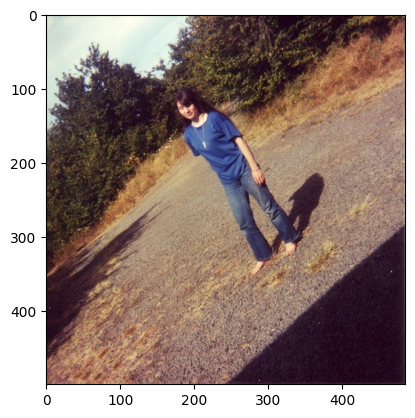

In [8]:
img_preprocess = input_tensor.squeeze(0).permute(1,2,0).to(torch.uint8).numpy()
print(img_origin.shape)
print(img_preprocess.shape)
plt.imshow(img_origin)
# plt.imshow(img_preprocess)

In [9]:
boxes_list = torch.randn((10,4))
mask = torch.randn((10)) > 0
print(mask)

tensor([False,  True, False, False,  True, False, False, False,  True,  True])


In [10]:
boxes = boxes_list[mask]
print(boxes.shape)

torch.Size([4, 4])


In [11]:
# 加载class_map
import joblib
class_map = joblib.load("datasets/class_map.joblib")
VOC_CLASS = [x for x in class_map.keys()]
print(VOC_CLASS)

['person', 'bird', 'bus', 'car', 'sofa', 'cat', 'chair', 'cow', 'motorbike', 'bicycle', 'bottle', 'diningtable', 'dog', 'pottedplant', 'aeroplane', 'train', 'horse', 'boat', 'tvmonitor', 'sheep']


In [12]:
boxes,labels,probs = postprocess(out_tensor,448,448,VOC_CLASS,7,2,0.1,0.1,0.5,20)
print(len(boxes))

1


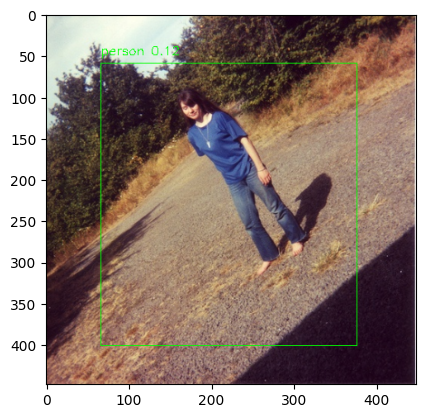

In [13]:
img = cv2.resize(img_origin,(448,448))
for i in range(len(boxes)):
    (x_min,y_min),(x_max,y_max) = boxes[i]
    x_min = x_min.item()
    y_min = y_min.item()
    x_max = x_max.item()
    y_max = y_max.item()
    label_show = f"{labels[i]} {probs[i]:.2f}"
    cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 1)
    cv2.putText(img, label_show, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
plt.imshow(img)

In [83]:
x = torch.randn(10)
_,idx = x.sort(0,True)

In [85]:
print(idx.shape,idx.numel())
print(idx)

torch.Size([10]) 10
tensor([5, 0, 2, 9, 7, 8, 6, 3, 4, 1])
